#### 익스 목표

1. 추천시스템의 개념과 목적을 이해한다.

2. Implicit 라이브러리를 활용하여 Matrix Factorization(이하 MF) 기반의 추천 모델을 만들어 본다.

3. 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해 본다.

4. 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다

5. 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.

6. 새로운 데이터셋으로 직접 추천 모델을 만들어 본다.

#### 목차

1. 데이터 탐색하기와 전처리

2. 사용자의 명시적/암묵적 평가

3. Matrix Factorization(MF)

4. CSR(Compressed Sparse Row) Matrix

5. MF 모델 학습하기

6. 비슷한 아티스트 찾기 + 유저에게 추천하기

7. 프로젝트 - MovieLens 영화 추천 실습

### 추천시스템

- 정의: 나와 좋아하는 것이 유사한 다른 사용자들의 선택을 내게도 추천해준다.

- 원리: 협업 필터링 방식 과 콘텐츠기반 필터링 방식


*협업 필터링 방식
 
  - 정의: 아이템-사용자(관계)에 초점.
  
  - 특징: 정확한 추천이 가능케함.(in 다수의 취향 및 아이템)
  
  - 제약조건
   
        1. 주어진 정보량 부족으로 사용자나 아이템 추론 불가(cold start)
        
        2. 계산량이 많아 추천 효율 떨어짐
        
        3. 관심도가 저조하면 추천에서 배제
  
*콘텐츠 기반 필터림

  - 정의: 아이템 속성에만 초점

### 디렉토리 생성 및 심볼릭 링크 걸기

In [1]:
! mkdir -p ~/aiffel/recommendata_iu/data/lastfm-dataset-360K
! ln -s ~/data/lastfm-dataset-360K/* ~/aiffel/recommendata_iu/data/lastfm-dataset-360K

#### 파싱하여 데이터 열기

In [2]:
! more ~/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv

00000c289a1829a808ac09c00daf10bc3c4e223b	3bd73256-3905-4f3a-97e2-8b341527
f805	betty blowtorch	2137
00000c289a1829a808ac09c00daf10bc3c4e223b	f2fb0ff0-5679-42ec-a55c-15109ce6
e320	die Ärzte	1099
00000c289a1829a808ac09c00daf10bc3c4e223b	b3ae82c2-e60b-4551-a76d-6620f1b4
56aa	melissa etheridge	897
00000c289a1829a808ac09c00daf10bc3c4e223b	3d6bbeb7-f90e-4d10-b440-e153c0d1
0b53	elvenking	717
00000c289a1829a808ac09c00daf10bc3c4e223b	bbd2ffd7-17f4-4506-8572-c1ea58c3
f9a8	juliette & the licks	706
00000c289a1829a808ac09c00daf10bc3c4e223b	8bfac288-ccc5-448d-9573-c33ea2aa
5c30	red hot chili peppers	691
00000c289a1829a808ac09c00daf10bc3c4e223b	6531c8b1-76ea-4141-b270-eb1ac5b4
1375	magica	545
00000c289a1829a808ac09c00daf10bc3c4e223b	21f3573f-10cf-44b3-aeaa-26cccd84
48b5	the black dahlia murder	507
00000c289a1829a808ac09c00daf10bc3c4e223b	c5db90c4-580d-4f33-b364-fbaa5a3a
58b5	the murmurs	424
00000c289a1829a808ac09c00daf10bc3c4e223b	0639533a-0402-40ba-b6e0-18b06719
8b73	lunachicks	403
00000c289a1829a80

#### 데이터 속

열어 보니 4개의 항목이 있네요.

User ID, Artist MBID, ArtistName, play

#### 데이터 탐색 및 전처리

1. 데이터 준비

  tsv파일,pandas이용

In [4]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


In [5]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [6]:
data['artist'] = data['artist'].str.lower() # 검색을 쉽게하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [7]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


#### 데이터 탐색

In [8]:
# 유저 수
data['user_id'].nunique()

358868

In [9]:
# 아티스트 수
data['artist'].nunique()

291346

In [10]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

In [11]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

#### 사용자 초기 정보 세팅


In [12]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


### 전처리 과정

In [14]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [15]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


In [16]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


#### 사용자의 암묵적/ 명시적 평가

1. 사용자의 명시적 평가

 - 정의: 좋아요나 싫어요 처럼 선호도 표현
 
2.  암묵적 평가

 - 정의: 서비스 이용 시 자연스럽게 나오는 것

In [18]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740,17535660
Ratio of only_one over all data is 0.84%


Matrix Factorization(MF)

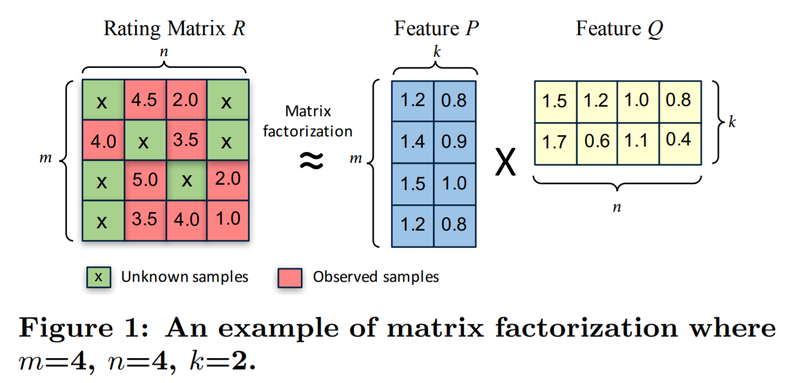

CSR

In [20]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data


<358869x291347 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Row format>

### MF학습

In [21]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [22]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [23]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [25]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [27]:
zimin_vector

array([ 0.7720643 , -0.18345468, -0.33327276, -0.90296364, -0.8615946 ,
        0.6181655 ,  0.4893474 , -0.64069813, -0.8379818 , -0.53348833,
       -0.6779685 ,  0.8953477 ,  0.32919598,  0.35617456, -0.64002943,
       -0.51004314, -0.1130871 ,  0.08080718,  0.10324941, -0.64978015,
        0.79109097, -0.31746584,  1.1532634 ,  0.06383924,  0.30492744,
        0.07798409, -0.7864684 , -0.02470487, -0.0496147 ,  1.281515  ,
        0.07941691, -1.1088289 ,  0.6167818 , -0.21413171,  0.25163957,
        1.42103   , -0.3293392 , -0.19358568, -0.57024693, -0.18404438,
        1.0684929 ,  0.90203995,  0.263972  , -0.515601  ,  0.17429323,
       -0.79546016,  0.46631715, -1.2139276 ,  1.2992597 ,  0.08985092,
       -0.5730429 ,  0.40748185, -0.2325906 ,  0.265274  ,  0.7814783 ,
        0.3239611 , -0.12197857, -0.49675342, -0.9192513 ,  0.7364364 ,
        1.7573793 , -0.4385757 , -0.33177677, -0.21415123,  1.2072042 ,
       -0.7901631 ,  0.26731667, -0.02075442, -1.5833632 , -0.06

In [28]:
black_eyed_peas_vector

array([ 0.01442263,  0.01440923, -0.00960477,  0.00098082, -0.0009073 ,
        0.00166437,  0.00614758, -0.01228264, -0.01208345, -0.00411558,
        0.01224744,  0.02297821,  0.00564852,  0.00943425, -0.01018419,
        0.00037998, -0.00028565,  0.0100395 ,  0.0032311 , -0.01475027,
        0.01564373,  0.00979066,  0.02387323,  0.01783896, -0.00054897,
        0.01448504, -0.0003416 , -0.00288518, -0.00072228,  0.03563047,
        0.00265604,  0.00538428,  0.00860485,  0.02492763,  0.0185833 ,
        0.01587866,  0.0046726 , -0.01188782, -0.0112362 ,  0.01938818,
        0.01130874,  0.0010251 ,  0.00550369, -0.00949337,  0.01226601,
       -0.00059359,  0.02672212, -0.00733021,  0.01388528, -0.0074651 ,
        0.01071398,  0.00709502, -0.01112989,  0.01791933,  0.01327185,
        0.01735744,  0.00635517,  0.00198959, -0.00501641,  0.00690581,
        0.01783688,  0.01065445,  0.01149882,  0.01621116,  0.03127439,
        0.01028134,  0.00907476,  0.002959  , -0.01350137, -0.00

In [29]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.50092524

In [30]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.3246352

In [31]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 1.0000001),
 (277, 0.98428816),
 (28, 0.9791693),
 (5, 0.97393113),
 (217, 0.97192055),
 (473, 0.9610301),
 (247, 0.9584477),
 (910, 0.9515994),
 (490, 0.9488712),
 (55, 0.94774526),
 (782, 0.9464696),
 (694, 0.94377047),
 (418, 0.93835557),
 (1018, 0.9365728),
 (75, 0.93102694)]

In [32]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'red hot chili peppers',
 'radiohead',
 'placebo',
 'the beatles',
 'nirvana',
 'oasis',
 'arctic monkeys',
 'the white stripes',
 'foo fighters',
 'u2',
 'the smashing pumpkins',
 'queen']

In [33]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("슝=3")

슝=3


In [34]:
get_similar_artist('2pac')

['2pac',
 'nas',
 'notorious b.i.g.',
 'jay-z',
 'dr. dre',
 'the game',
 '50 cent',
 'snoop dogg',
 'ludacris',
 'common']

In [35]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'christina aguilera',
 'kelly clarkson',
 'justin timberlake',
 'timbaland']

In [36]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(350, 0.45509583),
 (369, 0.44792473),
 (550, 0.4460039),
 (354, 0.43498635),
 (409, 0.43158448),
 (274, 0.43045074),
 (1800, 0.42718953),
 (355, 0.42430907),
 (627, 0.421546),
 (564, 0.4165507),
 (2249, 0.39557263),
 (382, 0.39447057),
 (5555, 0.38572696),
 (901, 0.3741445),
 (391, 0.37086424),
 (724, 0.36759365),
 (1777, 0.36393398),
 (621, 0.35978287),
 (24, 0.35970086),
 (2902, 0.3560942)]

In [37]:
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'justin timberlake',
 'britney spears',
 'nelly furtado',
 'amy winehouse',
 'michael jackson',
 'lady gaga',
 'madonna',
 'maroon 5',
 'kanye west',
 'katy perry',
 'mika',
 'timbaland',
 'pink',
 'christina aguilera',
 'lily allen',
 'mariah carey',
 'alicia keys',
 'jack johnson',
 'james blunt']

In [38]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [39]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.2164366846688375),
 ('black eyed peas', 0.12268626630814848),
 ('jason mraz', 0.0746052963455936),
 ('coldplay', 0.044821437033081196),
 ('maroon5', -0.0008301240611235356)]